In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "EMERGENCY"]


In [2]:
data = pd.read_excel('/content/Final.xlsx')
data.head()

,Time [s],HR,PULSE,RESP,SpO2,SYS,DIA,Alarm HR,Alarm PULSE,Alarm RESP,Alarm SpO2,Alarm SYS,Alarm DIA,Alarm
0,0,94.0,93.0,25.0,97.0,118.0,75.0,False,False,False,False,False,False,False
1,1,94.0,93.0,25.0,97.0,118.0,75.0,False,False,False,False,False,False,False
2,2,94.0,93.0,25.0,97.0,118.0,75.0,False,False,False,False,False,False,False
3,3,92.0,93.0,26.0,97.0,118.0,75.0,False,False,False,False,False,False,False
4,4,93.0,93.0,26.0,97.0,118.0,75.0,False,False,False,False,False,False,False


In [3]:
columns_to_delete = [ 'Time [s]','Alarm HR',	'Alarm PULSE',	'Alarm RESP',	'Alarm SpO2',	'Alarm SYS',	'Alarm DIA']
data.drop(columns=columns_to_delete, inplace=True)

data.dropna( inplace = True)
data.reset_index(drop = True, inplace = True)

data.head()

,HR,PULSE,RESP,SpO2,SYS,DIA,Alarm
0,94.0,93.0,25.0,97.0,118.0,75.0,False
1,94.0,93.0,25.0,97.0,118.0,75.0,False
2,94.0,93.0,25.0,97.0,118.0,75.0,False
3,92.0,93.0,26.0,97.0,118.0,75.0,False
4,93.0,93.0,26.0,97.0,118.0,75.0,False


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20233 entries, 0 to 20232
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0    HR     20233 non-null  float64
 1    PULSE  20233 non-null  float64
 2    RESP   20233 non-null  float64
 3    SpO2   20233 non-null  float64
 4   SYS     20233 non-null  float64
 5   DIA     20233 non-null  float64
 6   Alarm   20233 non-null  bool   
dtypes: bool(1), float64(6)
memory usage: 968.3 KB


In [5]:
data.dropna(inplace = True)
data.reset_index(drop = True, inplace = True)

columns_to_check = data.columns[data.columns != "Alarm"]
# columns_to_check = data.columns
data = data.loc[(data[columns_to_check] != 0).all(axis=1)]
#data = data.loc[(data != 0).all(axis=1)]

In [6]:
data.shape

(20013, 7)

In [7]:
data.head()

,HR,PULSE,RESP,SpO2,SYS,DIA,Alarm
0,94.0,93.0,25.0,97.0,118.0,75.0,False
1,94.0,93.0,25.0,97.0,118.0,75.0,False
2,94.0,93.0,25.0,97.0,118.0,75.0,False
3,92.0,93.0,26.0,97.0,118.0,75.0,False
4,93.0,93.0,26.0,97.0,118.0,75.0,False


## Exploratory Data Analysis

In [8]:
print(data['Alarm'].unique())

[False  True]


In [9]:
data.isnull().values.any()

False

In [10]:
data.loc[data['Alarm'] == True, 'Alarm'] = 1
data.loc[data['Alarm'] == False, 'Alarm'] = 0
print(data['Alarm'].unique())

[0 1]


In [11]:
data['Alarm'] = data['Alarm'].astype(float)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20013 entries, 0 to 20232
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0    HR     20013 non-null  float64
 1    PULSE  20013 non-null  float64
 2    RESP   20013 non-null  float64
 3    SpO2   20013 non-null  float64
 4   SYS     20013 non-null  float64
 5   DIA     20013 non-null  float64
 6   Alarm   20013 non-null  float64
dtypes: float64(7)
memory usage: 1.2 MB


Text(0, 0.5, 'Frequency')

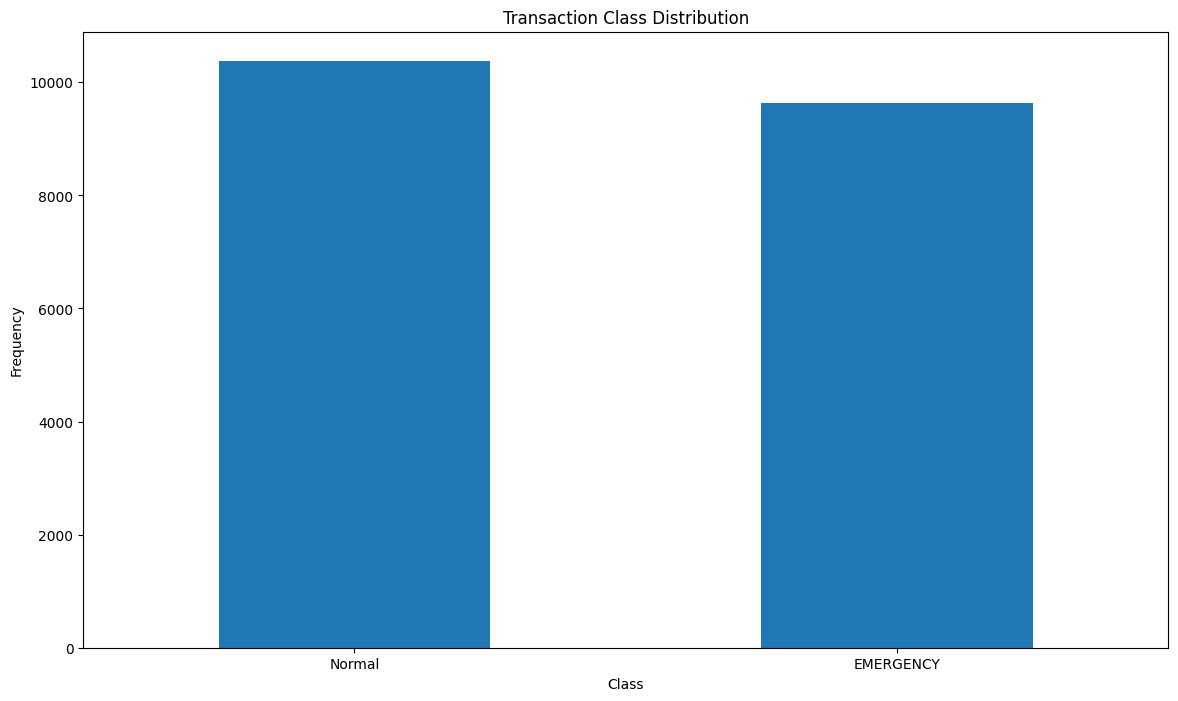

In [13]:
count_classes = pd.value_counts(data['Alarm'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [14]:
## Get the Fraud and the normal dataset

emergency = data[data['Alarm']==1]

normal = data[data['Alarm']==0]

In [15]:
print(emergency.shape,normal.shape)

(9637, 7) (10376, 7)


In [16]:
## Take some sample of the data

data1= data.sample(frac = 0.1)

data1.shape

(2001, 7)

In [17]:
data.shape

(20013, 7)

In [18]:
#Determine the number of fraud and valid transactions in the dataset

Emergency = data1[data1['Alarm']==1]

Valid = data1[data1['Alarm']==0]

outlier_fraction = len(Emergency)/float(len(Valid))

In [19]:
print(outlier_fraction)

print("Emergency Cases : {}".format(len(Emergency)))

print("Valid Cases : {}".format(len(Valid)))

0.8913043478260869
Emergency Cases : 943
Valid Cases : 1058


In [20]:
#Create independent and Dependent Features
columns = data1.columns.tolist()
# Filter the columns to remove data we do not want

columns = [c for c in columns if c not in ["Alarm"]]
# Store the variable we are predicting
target = "Alarm"
# Define a random state
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)


(2001, 6)
(2001,)


In [21]:
print(X_outliers)

[[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452]
 [0.05808361 0.86617615 0.60111501 0.70807258 0.02058449 0.96990985]
 [0.83244264 0.21233911 0.18182497 0.18340451 0.30424224 0.52475643]
 ...
 [0.77472162 0.94679117 0.10044042 0.15559032 0.96001266 0.03778422]
 [0.97763234 0.00464448 0.87366866 0.30732518 0.93858886 0.31694529]
 [0.65430632 0.08003257 0.24232981 0.77367935 0.52868585 0.92796906]]


In [22]:
smote = SMOTE(random_state=RANDOM_SEED)
X_resampled, y_resampled = smote.fit_resample(X, Y)

print(X_resampled.shape)
print( np.sum(y_resampled == 1))

(2116, 6)
1058


## Model Prediction





Now it is time to start building the model .The types of algorithms we are going to use to try to do anomaly detection on this dataset are as follows

### Isolation Forest Algorithm :
One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

How Isolation Forests Work
The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.


### Local Outlier Factor(LOF) Algorithm
The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [23]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X),
                                       contamination='auto',random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto',
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination='auto'),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05,
                                         max_iter=-1, )

}

In [24]:
type(classifiers)

dict

In [25]:
# n_outliers = len(Emergency)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
        # print(scores_prediction)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    print(scores_prediction.min())
    print(scores_prediction.max())
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred!=Y).sum()

    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

-0.1792087531045663
0.12334654425248748
Isolation Forest: 798
Accuracy Score :
0.6011994002998501
Classification Report :
              precision    recall  f1-score   support

         0.0       0.57      0.96      0.72      1058
         1.0       0.81      0.20      0.32       943

    accuracy                           0.60      2001
   macro avg       0.69      0.58      0.52      2001
weighted avg       0.68      0.60      0.53      2001

-10.079502200145114
-0.9233401565984692
Local Outlier Factor: 936
Accuracy Score :
0.5322338830584707
Classification Report :
              precision    recall  f1-score   support

         0.0       0.53      0.90      0.67      1058
         1.0       0.52      0.11      0.19       943

    accuracy                           0.53      2001
   macro avg       0.53      0.51      0.43      2001
weighted avg       0.53      0.53      0.44      2001

-10.079502200145114
-0.9233401565984692
Support Vector Machine: 970
Accuracy Score :
0.51524237881

#### Observations :
- Isolation Forest detected 73 errors versus Local Outlier Factor detecting 97 errors vs. SVM detecting 8516 errors
- Isolation Forest has a 99.74% more accurate than LOF of 99.65% and SVM of 70.09
- When comparing error precision & recall for 3 models , the Isolation Forest performed much better than the LOF as we can see that the detection of fraud cases is around 27 % versus LOF detection rate of just 2 % and SVM of 0%.
- So overall Isolation Forest Method performed much better in determining the fraud cases which is around 30%.
- We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases

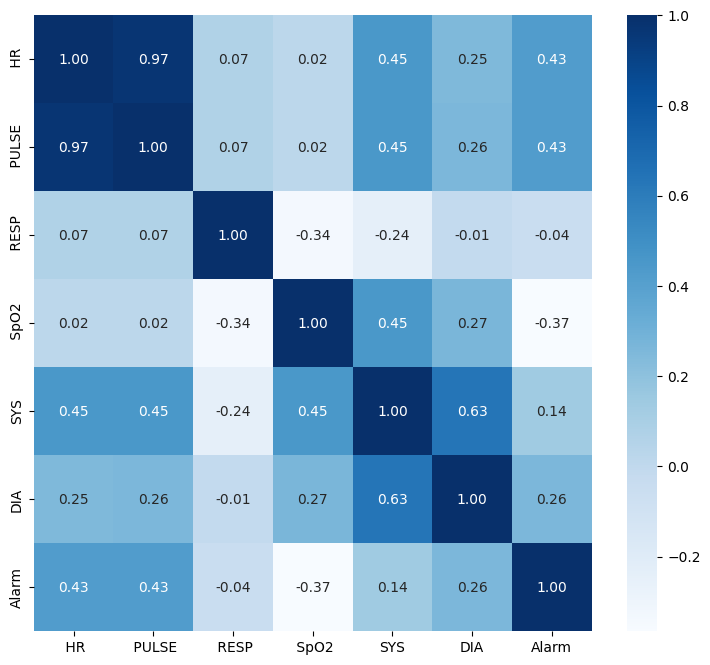

In [26]:
corr_matrix = data.corr()
plt.figure(figsize=(9, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.show()

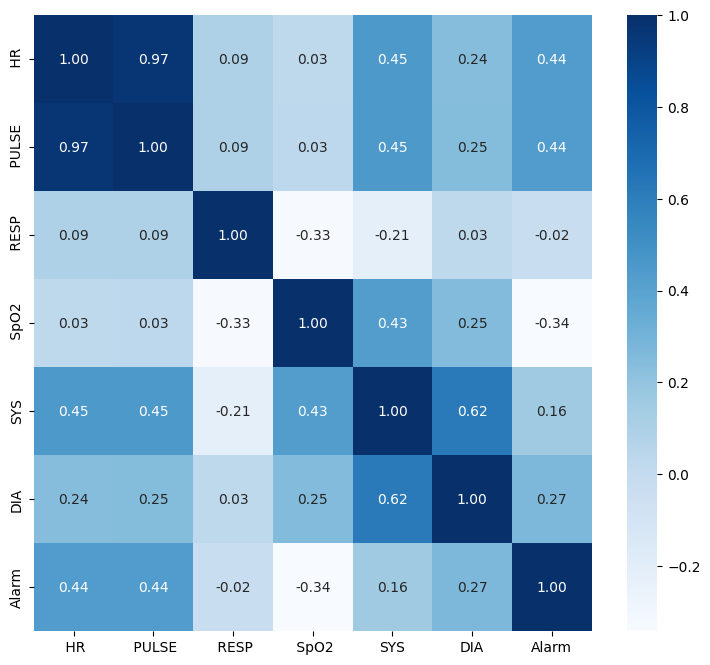

In [27]:
corr_matrix = data1.corr()
plt.figure(figsize=(9, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.show()